In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My Drive/Colab Notebooks/capstone

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/capstone


In [2]:
!pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 384.1 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from pytorch_tabnet.tab_model import TabNetClassifier

In [22]:
'''
params options

na_data will fill missing data with 'unknown', delete missing data or do nothing
input options are...
    * 'fill'
    * 'drop'
    * False

drop_outlier_days removes pets who have a lenght of stay exceeding the value YOU enter
input options are...
    * False
    * or any integer

sample_dict controls stratified sampling
    * stratify_col: a column name used for stratified sampling... spelling and caps must be exact
    * train_size: a fraction of data you want for the training data
    * validate_size: a fraction of data you want for the validate data
    * test_size: a fraction of data you want for the test data
'''

params = {
        'na_data': 'fill',
        'drop_outlier_days': 350,
        'embed':True,
        'num_buckets':5,
        'sample_dict':
            {
            'stratify_col':'Type',
            'train_size':0.6, 'validate_size':0.2, 'test_size':0.2
            }
        }


train_df, validate_df, test_df = load_df(params)
df = pd.concat([train_df, validate_df, test_df], ignore_index=True) # do this if you want to look at all the data still

Date Of Birth is NOT A STRING
Intake Date is NOT A STRING
Outcome Date is NOT A STRING
Days in Shelter is NOT A STRING
Count is NOT A STRING
replace null values in Name with 'Unknown'
replace null values in Size with 'Unknown'
replace null values in Outcome_Type with 'Unknown'
replace null values in Outcome_Subtype with 'Unknown'
replace null values in Outcome_Condition with 'Unknown'
replace null values in Outcome_Jurisdiction with 'Unknown'
replace null values in Outcome_Zip_Code with 'Unknown'
replace null values in Location with 'Unknown'


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
df.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date_Of_Birth',
       'Impound_Number', 'Kennel_Number', 'Animal_ID', 'Intake_Date',
       'Outcome_Date', 'Days_in_Shelter', 'Intake_Type', 'Intake_Subtype',
       'Outcome_Type', 'Outcome_Subtype', 'Intake_Condition',
       'Outcome_Condition', 'Intake_Jurisdiction', 'Outcome_Jurisdiction',
       'Outcome_Zip_Code', 'Location', 'Multiple_Visit_Count',
       'Age_inDays_at_Outcome', 'Age_Group', 'Is_Aggressive', 'Has_Name',
       'Is_Fixed', 'Is_Mixed_Breed', 'Is_Multicolor', 'Color_Embedding',
       'Color_Embedding_Cluster', 'Breed_Embedding', 'Breed_Embedding_Cluster',
       'Days_in_Shelter_Label'],
      dtype='object')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25252 entries, 0 to 25251
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Name                     25252 non-null  object        
 1   Type                     25252 non-null  object        
 2   Breed                    25252 non-null  object        
 3   Color                    25252 non-null  object        
 4   Sex                      25252 non-null  object        
 5   Size                     25252 non-null  object        
 6   Date_Of_Birth            25252 non-null  datetime64[ns]
 7   Impound_Number           25252 non-null  object        
 8   Kennel_Number            25252 non-null  object        
 9   Animal_ID                25252 non-null  object        
 10  Intake_Date              25252 non-null  datetime64[ns]
 11  Outcome_Date             25252 non-null  datetime64[ns]
 12  Days_in_Shelter          25252 n

In [25]:
df.describe()

,Date_Of_Birth,Intake_Date,Outcome_Date,Days_in_Shelter,Multiple_Visit_Count,Age_inDays_at_Outcome,Is_Aggressive,Has_Name,Is_Fixed,Is_Mixed_Breed,Is_Multicolor,Color_Embedding_Cluster,Breed_Embedding_Cluster
count,25252,25252,25252,25252.000000,25252.000000,25252.000000,25252.000000,25252.000000,25252.000000,25252.000000,25252.000000,25252.000000,25252.000000
mean,1991-09-03 00:25:56.787581056,2018-08-17 12:42:32.447330560,2018-09-04 21:07:02.556628992,18.350348,1.334865,9863.861872,0.049303,0.789205,0.633613,0.288769,0.512078,2.687589,1.808292
min,1900-01-01 00:00:00,2013-08-17 00:00:00,2014-01-01 00:00:00,0.000000,1.000000,-1336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006-03-30 12:00:00,2016-02-05 00:00:00,2016-02-23 00:00:00,1.000000,1.000000,275.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,2014-03-12 00:00:00,2018-04-14 00:00:00,2018-04-28 00:00:00,9.000000,1.000000,1115.000000,0.000000,1.000000,1.000000,0.000000,1.000000,4.000000,2.000000
75%,2017-08-19 00:00:00,2021-02-08 00:00:00,2021-02-25 00:00:00,24.000000,1.000000,4383.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000,3.000000
max,2024-05-12 00:00:00,2024-05-15 00:00:00,2024-05-16 00:00:00,338.000000,19.000000,45426.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000
std,NaN,NaN,NaN,28.865400,1.036737,17025.141398,0.216504,0.407881,0.481826,0.453199,0.499864,1.584628,1.194169


# Model V2

In [26]:
print(df['Days_in_Shelter_Label'].value_counts())

Days_in_Shelter_Label
0    7170
2    5017
4    4892
3    4671
1    3502
Name: count, dtype: int64


In [27]:
#
df['location_zipcode'] = df['Location'].str.extract(r'(\d+)(?=\()')
df['intake_year'] = df['Intake_Date'].dt.year
df['intake_month'] = df['Intake_Date'].dt.month
df['intake_day'] = df['Intake_Date'].dt.day

df['birth_year'] = df['Date_Of_Birth'].dt.year
df['birth_month'] = df['Date_Of_Birth'].dt.month
df['birth_day'] = df['Date_Of_Birth'].dt.day


In [28]:
df.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date_Of_Birth',
       'Impound_Number', 'Kennel_Number', 'Animal_ID', 'Intake_Date',
       'Outcome_Date', 'Days_in_Shelter', 'Intake_Type', 'Intake_Subtype',
       'Outcome_Type', 'Outcome_Subtype', 'Intake_Condition',
       'Outcome_Condition', 'Intake_Jurisdiction', 'Outcome_Jurisdiction',
       'Outcome_Zip_Code', 'Location', 'Multiple_Visit_Count',
       'Age_inDays_at_Outcome', 'Age_Group', 'Is_Aggressive', 'Has_Name',
       'Is_Fixed', 'Is_Mixed_Breed', 'Is_Multicolor', 'Color_Embedding',
       'Color_Embedding_Cluster', 'Breed_Embedding', 'Breed_Embedding_Cluster',
       'Days_in_Shelter_Label', 'location_zipcode', 'intake_year',
       'intake_month', 'intake_day', 'birth_year', 'birth_month', 'birth_day'],
      dtype='object')

In [29]:
df_model_v1 = df.drop(columns=[
  'Name',
  'Impound_Number',
  'Animal_ID',
  'Outcome_Date',
  'Days_in_Shelter',
  'Outcome_Type',
  'Outcome_Subtype',
  'Outcome_Condition',
  'Outcome_Jurisdiction',
  'Outcome_Zip_Code',
  'Location',
  'Intake_Date',
  'Date_Of_Birth',
  'location_zipcode',
  'Color_Embedding',
  'Breed_Embedding'
  ])
df_model_v1.columns

Index(['Type', 'Breed', 'Color', 'Sex', 'Size', 'Kennel_Number', 'Intake_Type',
       'Intake_Subtype', 'Intake_Condition', 'Intake_Jurisdiction',
       'Multiple_Visit_Count', 'Age_inDays_at_Outcome', 'Age_Group',
       'Is_Aggressive', 'Has_Name', 'Is_Fixed', 'Is_Mixed_Breed',
       'Is_Multicolor', 'Color_Embedding_Cluster', 'Breed_Embedding_Cluster',
       'Days_in_Shelter_Label', 'intake_year', 'intake_month', 'intake_day',
       'birth_year', 'birth_month', 'birth_day'],
      dtype='object')

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Encode categorical features
label_encoders = {}
for column in ['Type', 'Breed', 'Color', 'Sex', 'Size', 'Kennel_Number','Intake_Type','Intake_Subtype','Intake_Condition','Intake_Jurisdiction','Age_Group']:
    le = LabelEncoder()
    df_model_v1[column] = le.fit_transform(df_model_v1[column])
    label_encoders[column] = le

In [31]:
df_model_v1.dtypes

Type                          int64
Breed                         int64
Color                         int64
Sex                           int64
Size                          int64
Kennel_Number                 int64
Intake_Type                   int64
Intake_Subtype                int64
Intake_Condition              int64
Intake_Jurisdiction           int64
Multiple_Visit_Count          int64
Age_inDays_at_Outcome         int64
Age_Group                     int64
Is_Aggressive                 int64
Has_Name                      int64
Is_Fixed                      int64
Is_Mixed_Breed                int64
Is_Multicolor                 int64
Color_Embedding_Cluster       int32
Breed_Embedding_Cluster       int32
Days_in_Shelter_Label      category
intake_year                   int32
intake_month                  int32
intake_day                    int32
birth_year                    int32
birth_month                   int32
birth_day                     int32
dtype: object

In [32]:
# Define features and target
X = df_model_v1[['Type', 'Breed', 'Color', 'Sex', 'Size', 'Kennel_Number', 'Intake_Type',
       'Intake_Subtype', 'Intake_Condition', 'Intake_Jurisdiction',
       'Multiple_Visit_Count', 'Age_inDays_at_Outcome', 'Age_Group',
       'Is_Aggressive', 'Has_Name', 'Is_Fixed', 'Is_Mixed_Breed',
       'Is_Multicolor', 'Color_Embedding_Cluster', 'Breed_Embedding_Cluster', 'intake_year', 'intake_month', 'intake_day',
       'birth_year', 'birth_month', 'birth_day']]
y = df_model_v1['Days_in_Shelter_Label']

In [33]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Recursive Feature Elimination with Random Forest

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
# Perform Recursive Feature Elimination with Random Forest
model_rf_5 = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_5 = RFE(estimator=model_rf_5, n_features_to_select=5, step=1)
rfe_5.fit(X_train, y_train)

# Determine selected and eliminated features
# Get the ranking of the features
ranking_5 = rfe_5.ranking_
feature_names = X.columns

selected_features_5 = feature_names[rfe_5.support_]

print("Selected features:")
for feature in selected_features_5:
    print(feature)

Selected features:
Color
Kennel_Number
Age_inDays_at_Outcome
intake_day
birth_day


In [40]:
# Perform Recursive Feature Elimination with Random Forest
model_rf_6 = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_6 = RFE(estimator=model_rf_6, n_features_to_select=6, step=1)
rfe_6.fit(X_train, y_train)

# Determine selected and eliminated features
# Get the ranking of the features
ranking_6 = rfe_6.ranking_
feature_names = X.columns

selected_features_6 = feature_names[rfe_6.support_]

print("Selected features:")
for feature in selected_features_6:
    print(feature)


Selected features:
Breed
Color
Kennel_Number
Age_inDays_at_Outcome
intake_day
birth_day


In [41]:
# Perform Recursive Feature Elimination with Random Forest
model_rf_8 = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_8 = RFE(estimator=model_rf_8, n_features_to_select=8, step=1)
rfe_8.fit(X_train, y_train)

# Determine selected and eliminated features
# Get the ranking of the features
ranking_8 = rfe_8.ranking_
feature_names = X.columns

selected_features_8 = feature_names[rfe_8.support_]

print("Selected features:")
for feature in selected_features_8:
    print(feature)

Selected features:
Breed
Color
Kennel_Number
Age_inDays_at_Outcome
intake_year
intake_month
intake_day
birth_day


In [42]:
# Perform Recursive Feature Elimination with Random Forest
model_rf_10 = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_10 = RFE(estimator=model_rf_10, n_features_to_select=10, step=1)
rfe_10.fit(X_train, y_train)

# Determine selected and eliminated features
# Get the ranking of the features
ranking_10 = rfe_10.ranking_
feature_names = X.columns

selected_features_10 = feature_names[rfe_10.support_]

print("Selected features:")
for feature in selected_features_10:
    print(feature)

Selected features:
Breed
Color
Kennel_Number
Age_inDays_at_Outcome
intake_year
intake_month
intake_day
birth_year
birth_month
birth_day


In [43]:
# Perform Recursive Feature Elimination with Random Forest
model_rf_15 = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_15 = RFE(estimator=model_rf_15, n_features_to_select=15, step=1)
rfe_15.fit(X_train, y_train)

# Determine selected and eliminated features
# Get the ranking of the features
ranking_15 = rfe_15.ranking_
feature_names = X.columns

selected_features_15 = feature_names[rfe_15.support_]

print("Selected features:")
for feature in selected_features_15:
    print(feature)

Selected features:
Breed
Color
Size
Kennel_Number
Intake_Type
Intake_Subtype
Intake_Condition
Age_inDays_at_Outcome
Has_Name
intake_year
intake_month
intake_day
birth_year
birth_month
birth_day


In [49]:
# Perform Recursive Feature Elimination with Random Forest
model_rf_18 = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_18 = RFE(estimator=model_rf_18, n_features_to_select=18, step=1)
rfe_18.fit(X_train, y_train)

# Determine selected and eliminated features
# Get the ranking of the features
ranking_18 = rfe_18.ranking_
feature_names = X.columns

selected_features_18 = feature_names[rfe_18.support_]

print("Selected features:")
for feature in selected_features_18:
    print(feature)

Selected features:
Breed
Color
Sex
Size
Kennel_Number
Intake_Type
Intake_Subtype
Intake_Condition
Age_inDays_at_Outcome
Has_Name
Color_Embedding_Cluster
Breed_Embedding_Cluster
intake_year
intake_month
intake_day
birth_year
birth_month
birth_day


In [50]:
# Perform Recursive Feature Elimination with Random Forest
model_rf_20 = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_20 = RFE(estimator=model_rf_20, n_features_to_select=20, step=1)
rfe_20.fit(X_train, y_train)

# Determine selected and eliminated features
# Get the ranking of the features
ranking_20 = rfe_20.ranking_
feature_names = X.columns

selected_features_20 = feature_names[rfe_20.support_]

print("Selected features:")
for feature in selected_features_20:
    print(feature)

Selected features:
Breed
Color
Sex
Size
Kennel_Number
Intake_Type
Intake_Subtype
Intake_Condition
Intake_Jurisdiction
Age_inDays_at_Outcome
Has_Name
Is_Fixed
Color_Embedding_Cluster
Breed_Embedding_Cluster
intake_year
intake_month
intake_day
birth_year
birth_month
birth_day


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      1454
           1       0.39      0.28      0.33       639
           2       0.49      0.44      0.47       998
           3       0.44      0.42      0.43       897
           4       0.58      0.58      0.58      1063

    accuracy                           0.54      5051
   macro avg       0.51      0.50      0.50      5051
weighted avg       0.53      0.54      0.53      5051



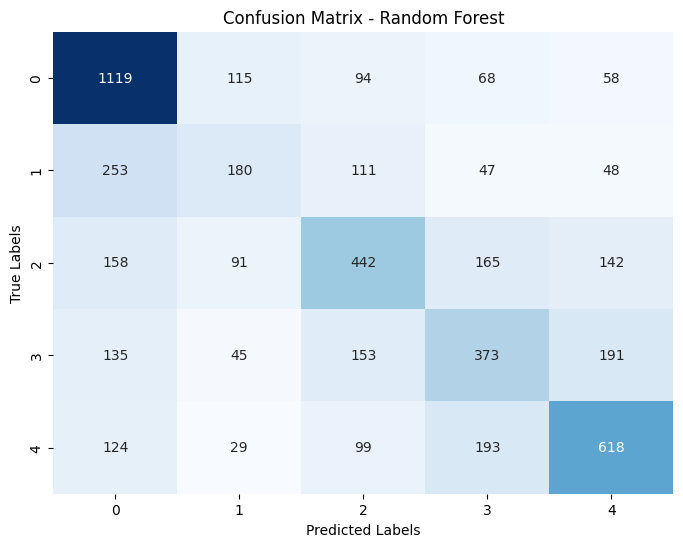

In [44]:
# Select features based on RFE
X_train_rfe_5 = rfe_5.transform(X_train)
X_test_rfe_5 = rfe_5.transform(X_test)

model_rf_5.fit(X_train_rfe_5,y_train)

# Predict and evaluate the model
y_pred_rf_5 = model_rf_5.predict(X_test_rfe_5)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_5))

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      1454
           1       0.42      0.28      0.34       639
           2       0.49      0.43      0.46       998
           3       0.46      0.42      0.44       897
           4       0.59      0.61      0.60      1063

    accuracy                           0.55      5051
   macro avg       0.52      0.50      0.50      5051
weighted avg       0.53      0.55      0.54      5051



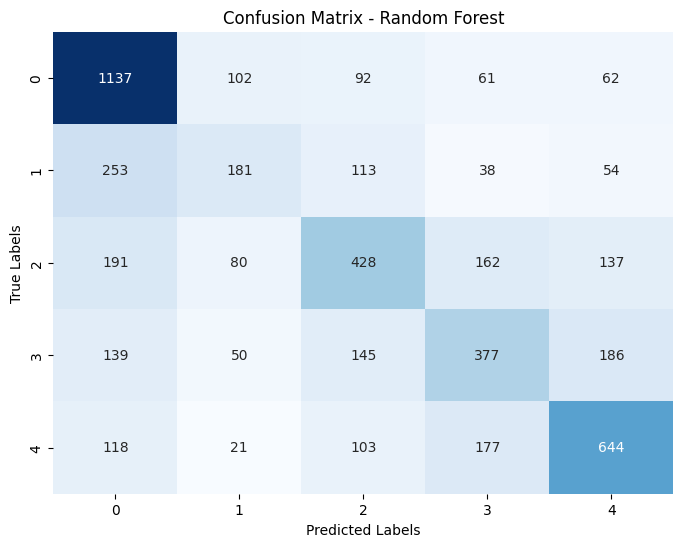

In [45]:
# Select features based on RFE
X_train_rfe_6 = rfe_6.transform(X_train)
X_test_rfe_6 = rfe_6.transform(X_test)

model_rf_6.fit(X_train_rfe_6,y_train)

# Predict and evaluate the model
y_pred_rf_6 = model_rf_6.predict(X_test_rfe_6)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_6))

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_6)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.82      0.70      1454
           1       0.47      0.29      0.36       639
           2       0.52      0.47      0.49       998
           3       0.46      0.41      0.43       897
           4       0.63      0.61      0.62      1063

    accuracy                           0.57      5051
   macro avg       0.54      0.52      0.52      5051
weighted avg       0.55      0.57      0.55      5051



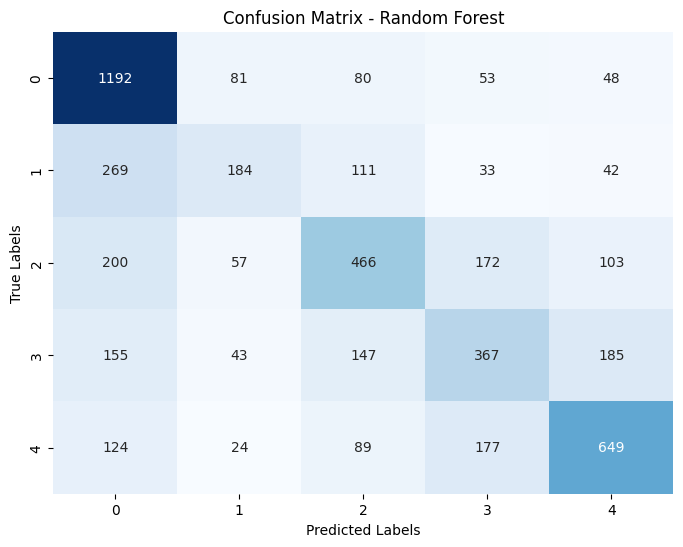

In [46]:
# Select features based on RFE
X_train_rfe_8 = rfe_8.transform(X_train)
X_test_rfe_8 = rfe_8.transform(X_test)

model_rf_8.fit(X_train_rfe_8,y_train)

# Predict and evaluate the model
y_pred_rf_8 = model_rf_8.predict(X_test_rfe_8)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_8))

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_8)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70      1454
           1       0.46      0.30      0.36       639
           2       0.54      0.48      0.51       998
           3       0.47      0.44      0.45       897
           4       0.66      0.63      0.65      1063

    accuracy                           0.57      5051
   macro avg       0.55      0.53      0.53      5051
weighted avg       0.56      0.57      0.56      5051



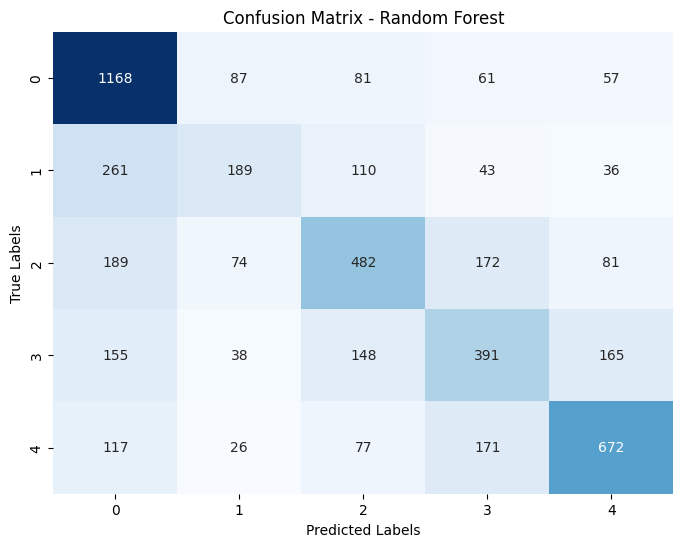

In [47]:
# Select features based on RFE
X_train_rfe_10 = rfe_10.transform(X_train)
X_test_rfe_10 = rfe_10.transform(X_test)

model_rf_10.fit(X_train_rfe_10,y_train)

# Predict and evaluate the model
y_pred_rf_10 = model_rf_10.predict(X_test_rfe_10)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_10))

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_10)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      1454
           1       0.51      0.31      0.38       639
           2       0.56      0.52      0.54       998
           3       0.49      0.44      0.46       897
           4       0.68      0.66      0.67      1063

    accuracy                           0.60      5051
   macro avg       0.58      0.56      0.56      5051
weighted avg       0.59      0.60      0.59      5051



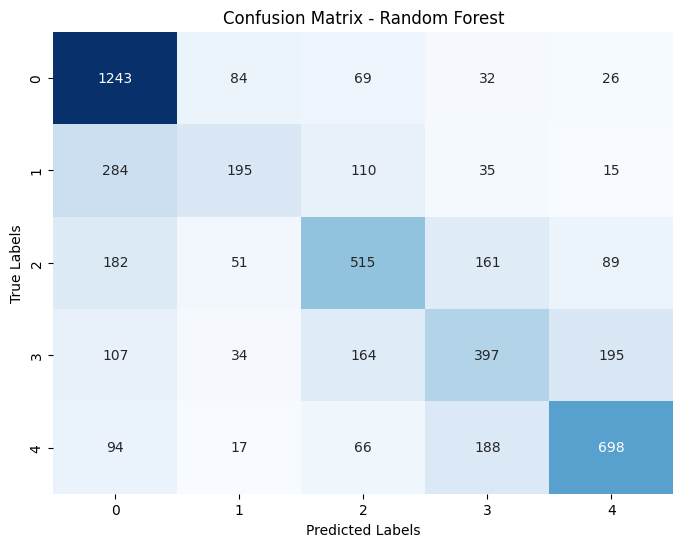

In [48]:
# Select features based on RFE
X_train_rfe_15 = rfe_15.transform(X_train)
X_test_rfe_15 = rfe_15.transform(X_test)

model_rf_15.fit(X_train_rfe_15,y_train)

# Predict and evaluate the model
y_pred_rf_15 = model_rf_15.predict(X_test_rfe_15)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_15))

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_15)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.86      0.75      1454
           1       0.49      0.31      0.38       639
           2       0.56      0.51      0.53       998
           3       0.47      0.44      0.45       897
           4       0.68      0.65      0.67      1063

    accuracy                           0.60      5051
   macro avg       0.57      0.55      0.56      5051
weighted avg       0.59      0.60      0.59      5051



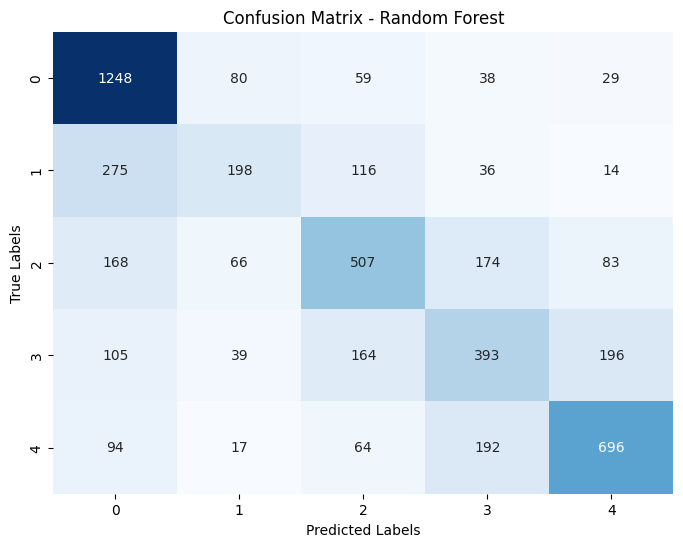

In [51]:
# Select features based on RFE
X_train_rfe_18 = rfe_18.transform(X_train)
X_test_rfe_18 = rfe_18.transform(X_test)

model_rf_18.fit(X_train_rfe_18,y_train)

# Predict and evaluate the model
y_pred_rf_18 = model_rf_18.predict(X_test_rfe_18)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_18))

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_18)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.85      0.74      1454
           1       0.50      0.31      0.38       639
           2       0.54      0.50      0.52       998
           3       0.50      0.45      0.47       897
           4       0.70      0.68      0.69      1063

    accuracy                           0.61      5051
   macro avg       0.58      0.56      0.56      5051
weighted avg       0.60      0.61      0.59      5051



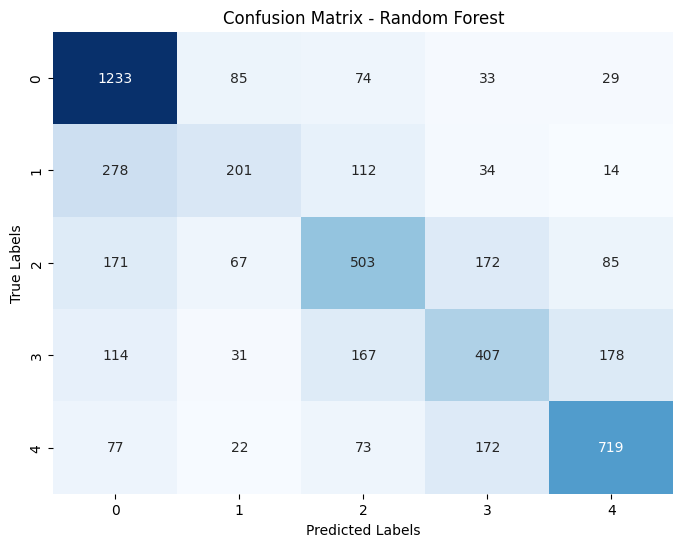

In [52]:
# Select features based on RFE
X_train_rfe_20 = rfe_20.transform(X_train)
X_test_rfe_20 = rfe_20.transform(X_test)

model_rf_20.fit(X_train_rfe_20,y_train)

# Predict and evaluate the model
y_pred_rf_20 = model_rf_20.predict(X_test_rfe_20)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_20))

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_20)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [19]:
# Get the ranking of the features
ranking = rfe_20.ranking_
feature_names = X.columns

print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{feature_names[i]}: {ranking[i]}")

Feature ranking:
Type: 22
Breed: 2
Color: 1
Sex: 13
Size: 10
Kennel_Number: 1
Intake_Type: 11
Intake_Subtype: 7
Intake_Condition: 8
Intake_Jurisdiction: 15
Multiple_Visit_Count: 17
Age_inDays_at_Outcome: 1
Age_Group: 19
Is_Aggressive: 20
Has_Name: 9
Is_Fixed: 16
Is_Mixed_Breed: 21
Is_Multicolor: 18
Color_Embedding_Cluster: 12
Breed_Embedding_Cluster: 14
intake_year: 4
intake_month: 3
intake_day: 1
birth_year: 6
birth_month: 5
birth_day: 1


In [ ]:
# Define a pipeline combining RFE with a classifier
def create_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('rfe', RFE(estimator=RandomForestClassifier(), n_features_to_select=5, step=1)),
        ('classifier', model)
    ])

# Define parameter grid for RandomForest (example)
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Define parameter grids for other models if needed
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

param_grid_gb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

# Models to try
models = {
    'RandomForest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), param_grid_gb),
    'XGBoost': (XGBClassifier(random_state=42), param_grid_xgb),
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), param_grid_lr)
}

best_models = {}
for model_name, (model, param_grid) in models.items():
    pipeline = create_pipeline(model)
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters found for {model_name}: ", grid_search.best_params_)

# Evaluate the best models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

Fitting 3 folds for each of 216 candidates, totalling 648 fits
